# **INCEPTION V3 - FLICKR DATASET**

# **1. Connect to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Import libraries**

In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
from PIL import Image
import urllib
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.9.0+cu102
Torchvision Version:  0.10.0+cu102


# **3. Define paths and classes**

In [ ]:
num_of_categories = 42
#define path dataset like dataset_name/preprocessed_dataset
#example path image: path/dataset_name/preprocessed_dataset/class_name/img_01.jpg
#path dataset
path= '/content/drive/MyDrive/Project FindPet/dataset/FlickrDogDataset'
#preprocessed dataset
pathData = path + '/original/Flickr-dog'
#define split dataset destination
dstPath = path + '/dataSplit'
#number of classes
class_list = sorted(os.listdir(pathData))
print(len(class_list))

42


# **4. Split dataset**
Only run one time correctly!

## **Split paths for each class of dataset and join**

In [ ]:
#split paths randomly in train, val and test
def split_class_dataset(path_dataset, test_split, val_split, manual_seed):
  total = len(path_dataset)
  num = int ((1-test_split)*total)
  train, test = torch.utils.data.random_split(path_dataset, [num,total-num], generator=torch.Generator().manual_seed(manual_seed))
  total = len(train)
  num = int ((1-val_split)*total)
  train, val = torch.utils.data.random_split(train, [num,total-num], generator=torch.Generator().manual_seed(manual_seed))
  return train, val, test

#split paths for each class in train, val, test
#then join
def split_dataset(class_list, pathData, test_split = 0.2, val_split = 0.1, manual_seed = 42):
  train, val, test = list(), list(), list()
  for class_name in class_list:
    base_name = pathData + "/{}/".format(class_name)
    list_image = os.listdir(base_name)
    list_image = [ base_name + item for item in list_image]
    train_aux, val_aux, test_aux = split_class_dataset(list_image, test_split, val_split, manual_seed)
    train += train_aux
    val += val_aux
    test += test_aux
  return train, val, test

In [ ]:
%%time
#run split dataset defined
test_split = 0.2
val_split = 0.1
manual_seed = 42
train, val, test = split_dataset(class_list, pathData, test_split, val_split, manual_seed)
print(len(train)+len(test)+len(val))
print(len(train))
print(len(val))
print(len(test))
print('Examples')
print(train[0])
print(val[0])
print(test[0])

374
237
47
90
Examples
/content/drive/MyDrive/Project FindPet/dataset/FlickrDogDataset/original/Flickr-dog/Apolo/Apolo__07-crp.png
/content/drive/MyDrive/Project FindPet/dataset/FlickrDogDataset/original/Flickr-dog/Apolo/Apolo__04-crp.png
/content/drive/MyDrive/Project FindPet/dataset/FlickrDogDataset/original/Flickr-dog/Apolo/Apolo__05-crp.png
CPU times: user 8.58 ms, sys: 3.4 ms, total: 12 ms
Wall time: 62.3 ms


## **Run split into directories train, val and test**

In [ ]:
#util function: create directory if it doesn't exist
def createDir(pathDir):
  valid = False
  try:
    if not os.path.exists(pathDir):
      os.makedirs(pathDir)
    valid = True
  except Exception as e:
    print('Error creating directory {}'.format(pathDir))
    print(e)
  return valid

#util function: copy file
def copyFile(src, dst):
  valid = False
  try:
    shutil.copyfile(src, dst)
    valid = True
  except Exception as e:
    print('Error copying file {} to {}'.format(src,dst))
    print(e)
  return valid

#util function: get class name and filename from path file
def get_class_name(path):
  #/content/drive/MyDrive/Ciclos/21/Project FindPet/dataset/StanfordDataset/data/n02085620-Chihuahua/n02085620_11818.jpg
  fileName = path[path.rfind('/')+1:]
  className = path[:path.rfind('/')]
  className = className[className.rfind('/')+1:]
  return className, fileName
  
#util function: remove directory recursively
def remove_dir(dir):
  try:
    shutil.rmtree(dir)
  except Exception as e:
    print('Error removing directory {}'.format(dir))
    print(e)


In [ ]:
#create dataset from origin path to destination path
def create_dataset(oriPaths, dstPath, kindDataset):
  path = dstPath + '/' + kindDataset
  print('{}: Starting...'.format(kindDataset))
  if not createDir(path):
    print('{}: Error creating destination dataset {}'.format(kindDataset, path))
    remove_dir(path)
    return False
  
  for path_img in oriPaths:
    className, imageName = get_class_name(path_img)
    dirDst = path + '/' + className
    if not createDir(dirDst):
      print('{}: Error creating destination dataset {}'.format(kindDataset, dirDst))
      remove_dir(path)
      return False
    dst = dirDst + '/' +   imageName
    if not copyFile(path_img, dst):
      print('{}: Error copying file {} to {}'.format(kindDataset, path_img, dst))
      remove_dir(path)
      return False
  print('{}: Finished {} files'.format(kindDataset, len(oriPaths)))
  return True
#create train, val and test dataset
def split_dir_dataset(train, val, test, dstPath):
  if create_dataset(train, dstPath, 'train') and create_dataset(val, dstPath, 'val') and create_dataset(test, dstPath, 'test'):
    return True
  return False

In [ ]:
%%time
#run and create train, val, and test dataset
dataset = split_dir_dataset(train, val, test, dstPath)
print('Dataset is created: {}'.format(dataset))

train: Starting...
train: Finished 237 files
val: Starting...
val: Finished 47 files
test: Starting...
test: Finished 90 files
Dataset is created: True
CPU times: user 870 ms, sys: 446 ms, total: 1.32 s
Wall time: 2min 1s


## **Sync, check split and show examples**

In [ ]:
#check number of files should be the same
!find /content/drive/MyDrive/Project\ FindPet/dataset/FlickrDogDataset/dataSplit -type f | wc -l
!find /content/drive/MyDrive/Project\ FindPet/dataset/FlickrDogDataset/original/Flickr-dog -type f | wc -l

379
374


In [ ]:
%%time
#flush drive or force sync with drive
drive.flush_and_unmount()

CPU times: user 24.9 ms, sys: 9.35 ms, total: 34.3 ms
Wall time: 4.77 s


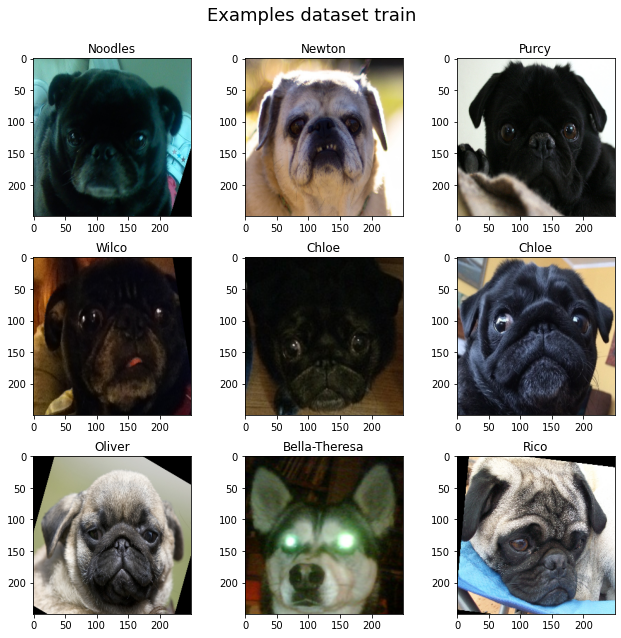

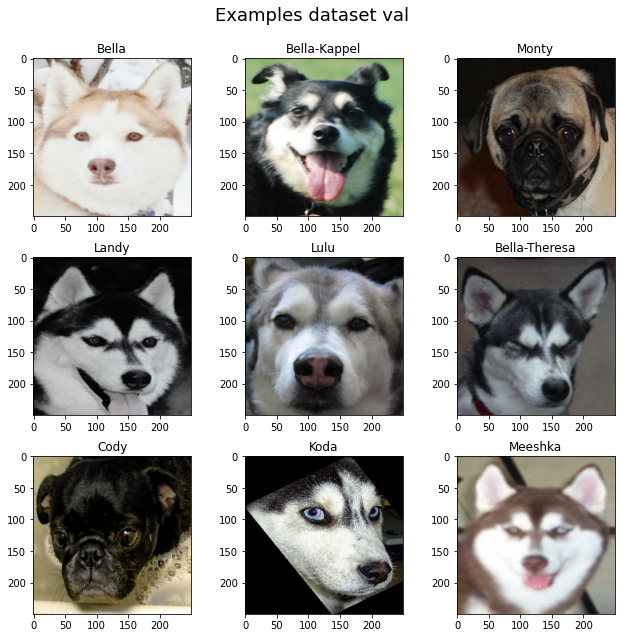

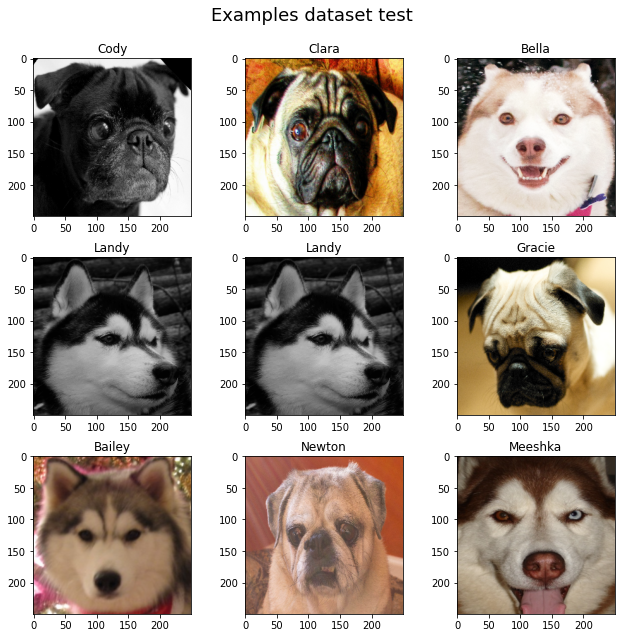

In [ ]:
#show examples of dataset split
for kind in ['train','val','test']:
  columns = 3
  rows = 3
  fig = plt.figure(figsize=(9, 9))
  for i in range(1,columns*rows+1):
    class_name = np.random.choice(class_list) # random class
    name = np.random.choice(os.listdir('{}/{}/{}'.format(dstPath,kind,class_name))) # random image 
    img = Image.open('{}/{}/{}/{}'.format(dstPath,kind,class_name,name))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(class_name)
  fig.tight_layout()#figure.tight_layout(pad=3.0)
  fig.suptitle('Examples dataset {}'.format(kind), fontsize=18)
  fig.subplots_adjust(top=0.90)
  plt.show()
  print()



# **5. Define parameters and initialize model**

In [ ]:
#if feature_extracting is true only use the weigths from the pretained model
#and update the parameters only of the layer that we added

#if feature_extracting is false the weights from pretrained model can be updated
#or you can use it if you want to train the model from scratch
#(update all the parameters, model parameters and new parameters)
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
#define hiperparameters
data_dir = dstPath

# Number of classes in the dataset
num_classes = num_of_categories

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for 
num_epochs = 100

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

#Flag for use pretained weights of the model
use_pretrained=True

In [ ]:
#initialize
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    """ Inception v3
    Be careful, expects (299,299) sized images and has auxiliary output
    """
    model_ft = models.inception_v3(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    # Handle the auxilary net
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    # Handle the primary net
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
    input_size = 299

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth



Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), str

# **6. Train function**

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    hist = {}
    hist['accuracy_train']=[]
    hist['accuracy_val']=[]
    hist['loss_train']=[]
    hist['loss_val']=[]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 30)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch + 1
                best_model_wts = copy.deepcopy(model.state_dict())
            #tensorboard graphs
            writer.add_scalar('Loss/' + phase, epoch_loss, epoch)
            writer.add_scalar('Accuracy/' + phase, epoch_acc, epoch)

            writer.add_histogram('Loss/' + phase, epoch_loss, epoch)
            writer.add_histogram('Accuracy/' + phase, epoch_acc, epoch)
            #pyplot graphs
            hist['accuracy_' + phase].append(epoch_acc)
            hist['loss_' + phase].append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('-' * 80)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} in Epoch {}'.format(best_acc, best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, hist

# **7. Load dataset and data augmentation**

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation and testing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val','test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val','test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:' , device)

Initializing Datasets and Dataloaders...
Device: cuda:0


# **8. Define optimizer and parameters to learn**

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [ ]:
#initialize tensorboard
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
pathTb = data_dir + '/run_InceptionV3_FlickrDogDataset'
writer = SummaryWriter(pathTb)

# **9. Run train and save model**

# Run train

In [ ]:
#Only the weights of the added layers are being updated

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 1/100
------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 5.2848 Acc: 0.0253
val Loss: 3.7284 Acc: 0.0426

Epoch 2/100
------------------------------
train Loss: 5.2440 Acc: 0.0253
val Loss: 3.6848 Acc: 0.0851

Epoch 3/100
------------------------------
train Loss: 5.1274 Acc: 0.0886
val Loss: 3.6615 Acc: 0.0426

Epoch 4/100
------------------------------
train Loss: 5.0521 Acc: 0.0802
val Loss: 3.6493 Acc: 0.0426

Epoch 5/100
------------------------------
train Loss: 5.0164 Acc: 0.0886
val Loss: 3.6313 Acc: 0.0426

Epoch 6/100
------------------------------
train Loss: 4.9461 Acc: 0.0844
val Loss: 3.6039 Acc: 0.0638

Epoch 7/100
------------------------------
train Loss: 4.8681 Acc: 0.0970
val Loss: 3.5811 Acc: 0.0638

Epoch 8/100
------------------------------
train Loss: 4.8150 Acc: 0.1308
val Loss: 3.5607 Acc: 0.1064

Epoch 9/100
------------------------------
train Loss: 4.7273 Acc: 0.1941
val Loss: 3.5328 Acc: 0.0851

Epoch 10/100
------------------------------
train Loss: 4.6826 Acc: 0.1688
val Loss: 3.5128 Acc: 0.1277

Ep

# Save the best model

In [ ]:
import datetime

PATH = path + '/InceptionV3_Flickr_entire_{}.pt'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Save
torch.save(model_ft, PATH)

PATH = path + '/InceptionV3_Flickr_state_dict_{}.pt'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Save
torch.save(model_ft.state_dict(), PATH)

# **10. Run test**

# Test from Dataset and Batch

In [ ]:
def test_model(model, dataloader, criterion):
    since = time.time()

    model.eval()

    running_loss = 0.0
    running_corrects = 0
    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(dataloader.dataset)
    acc = running_corrects.double() / len(dataloader.dataset)

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(loss, acc))
    time_elapsed = time.time() - since
    print('-' * 80)
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return loss, acc

In [ ]:
test_loss, test_accuracy = test_model(model_ft,dataloaders_dict['test'],criterion)

Test Loss: 2.3379 Acc: 0.4667
--------------------------------------------------------------------------------
Test complete in 0m 26s


In [ ]:
#finalize writer of tensorboard
writer.flush()
writer.close()

# Unit test

In [ ]:

def download_and_predict(url, filename, n_top):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((299, 299))
    #img.save(filename)
    # predict
    #img = image.imread(filename)
    img = data_transforms['test'](img)
    #img = preprocess_input(img)
    #probs = my_model.predict(np.expand_dims(img, axis=0))
    model_ft.eval()
    with torch.set_grad_enabled(False):
        outputs = model_ft(img)
        _, preds = torch.max(outputs, 1)

    for idx in preds.argsort()[0][::-1][:n_top]:
        print("{:.2f}%".format(preds[0][idx]*100), "\t", class_list[idx].split("-")[-1])

In [ ]:

def download_and_predict(url, filename, n_top):
  """url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
  try: urllib.URLopener().retrieve(url, filename)
  except: urllib.request.urlretrieve(url, filename)"""
  os.system("curl -s {} -o {}".format(url, filename))
  input_image = Image.open(filename)
  # show image
  plt.figure(figsize=(4, 4))
  plt.imshow(input_image)
  plt.axis('off')
  input_tensor = data_transforms['test'](input_image)
  input_batch = input_tensor.unsqueeze(0)
  input_batch = input_batch.to(device)
  model_ft.to(device)
  with torch.no_grad():
    output = model_ft(input_batch)
  # Tensor of shape n_classes, with confidence scores
  #print(output[0])
  # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
  preds = torch.nn.functional.softmax(output[0], dim=0)
  #print(preds)
  topn_prob, topn_catid = torch.topk(preds, n_top)
  for i in range(topn_prob.size(0)):
      print("{:.2f}%".format(topn_prob[i].item()*100), "\t", class_list[topn_catid[i]].split("-")[-1])
      #print(class_list[topn_catid[i]], topn_prob[i].item())

12.82% 	 Lulu
11.59% 	 Meeshka
6.94% 	 Zowie
6.10% 	 Skipper
4.72% 	 Injun


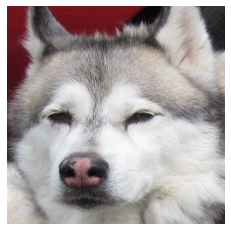

In [ ]:
download_and_predict("https://i.ibb.co/XYLJSNv/Lulu-06-crp.png",
                     "test_1.jpg",5)

# **11. Results and graphics**

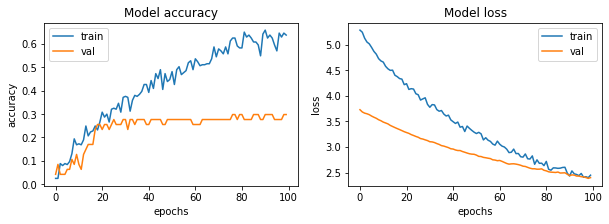

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist[met + '_train'])
    ax[i].plot(hist[met + '_val'])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])